# GEODOS data processing

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
%pylab inline --no-import-all

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Read Logfile

In [3]:
dto = '/storage/stations/Polednik/geodos/2021/08/10/210812'
dto = '/storage/stations/Polednik/geodos/2021/08/13/210720'

dto = '/storage/stations/Polednik/geodos/2021/10/10'
#dto = '/storage/stations/Polednik/geodos/2021/10/13'
#dto = '/storage/stations/Polednik/geodos/2021/10/EC'

#dto = '/storage/experiments/2021/11_geodos10_calibration'
#dto = '/storage/experiments/2021/05_GEODOS_kalibrace/GEO1'
#dto = '/storage/experiments/2021/12_test_geodos1024/12k_Zn65_LS'
dto = '/storage/stations/Kosetice/GEODOS'

#fto = dto + '/DATALOG.TXT'
fto = dto + '/0.TXT'

l=[]
l.extend(range(0,800))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

# keep only last run
#df.drop(df.index[:last[-1:][0]], inplace=True) 

s.n.:  1290c00806a200921812a000a0000045
f.v.:  NaI(Tl)-D18x30
0         GEO_1024_v4
1         GEO_1024_v4
12        GEO_1024_v4
106224    GEO_1024_v4
212436    GEO_1024_v4
Name: 1, dtype: object
318550
212436


## Fill position and time (Galileo)

In [4]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df = df.fillna(method='ffill')
df.meas = df.meas.astype(int)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,799,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
2,$HIST,0,22.87,937.94,19.31,2.70,-21,90,0,34216,...,NaN,False,NaN,22870.0,NaN,NaN,NaN,NaT,2,NaT
3,$HITS,47,2731,35,3001,87,3050,111,3809,64,...,NaN,False,NaN,22870.0,NaN,NaN,NaN,NaT,2,NaT
4,$HIST,1,35.68,937.94,19.31,2.70,-24,180,0,34195,...,NaN,False,NaN,35680.0,NaN,NaN,NaN,NaT,4,NaT
5,$HITS,32,1921,47,3613,34,3779,170,4816,39,...,NaN,False,NaN,35680.0,NaN,NaN,NaN,NaT,4,NaT
6,$HIST,2,48.47,937.94,19.31,2.70,-25,254,1,34220,...,NaN,False,NaN,48470.0,NaN,NaN,NaN,NaT,6,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318641,$HITS,7,1505,539,16660,110,22463,204,43327,797,...,NaN,False,652544540.0,694667680.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318640,2023-02-10 15:35:44.140
318642,$HIST,52999,694680.80,944.45,-1.88,2.74,-13,2917,0,34348,...,NaN,False,652544540.0,694680800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318642,2023-02-10 15:35:57.260
318643,$HITS,7,11244,70,15763,30,25020,47,51516,52,...,NaN,False,652544540.0,694680800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318642,2023-02-10 15:35:57.260
318644,$HIST,53000,694704.80,944.47,-1.88,2.74,-14,10,1,34347,...,NaN,False,652544540.0,694704800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318644,2023-02-10 15:36:21.260


## Add individual events to histogram

In [5]:
df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:20].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [6]:
hits.iloc[:,40:300] = 0
for i in range(len(hits)):
    for j in range(hits.iloc[i,1]):
        hits.iloc[i,int(40+hits.iloc[i,j*2+3])] +=1
#hits.merge(hist)
#hits.drop(hits.iloc[:,18:40], axis=1, inplace=True)
histogram = pd.DataFrame()
histogram = hist.iloc[:,11:18]
histogram = histogram.join(hits.iloc[:,40+11:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:258],range(0,258))})
#histogram.to_csv(dto + '/histogram.csv')
histogram

IndexError: index 880 is out of bounds for axis 0 with size 808

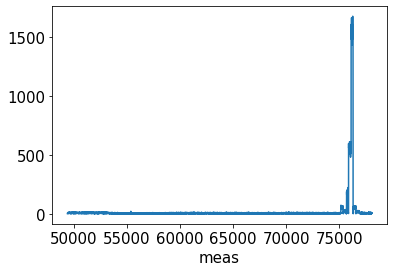

In [23]:
hist.iloc[:,11].plot()

## Plot Flux

/tmp/ipykernel_15856/3311982883.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_15856/3311982883.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


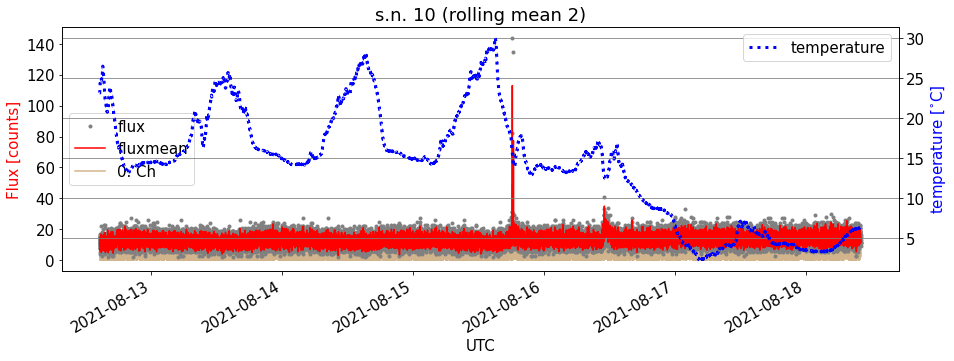

In [16]:
NOISE_LEVEL = 0
LAST_CHANNEL = 256
WINDOW = 2

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2021-05-12 8:35:00':'2021-05-12 12:45:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



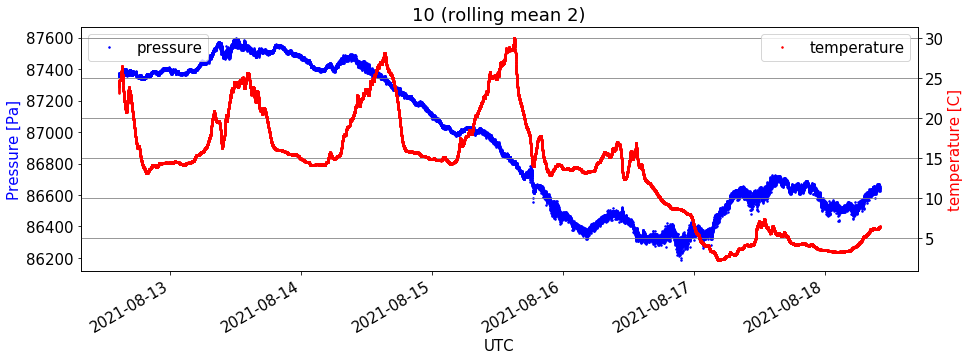

In [7]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



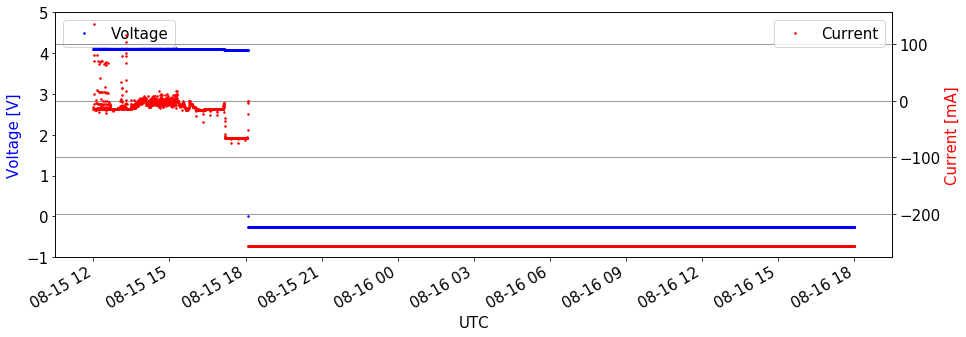

In [8]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 00:00:00':'2021-08-16 00:00:00']
xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([-1,5])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_15856/4081771715.py:15: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc['2021-08-15 15:00:00':'2021-08-15 20:00:00']
/tmp/ipykernel_15856/4081771715.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_15856/4081771715.py:40: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


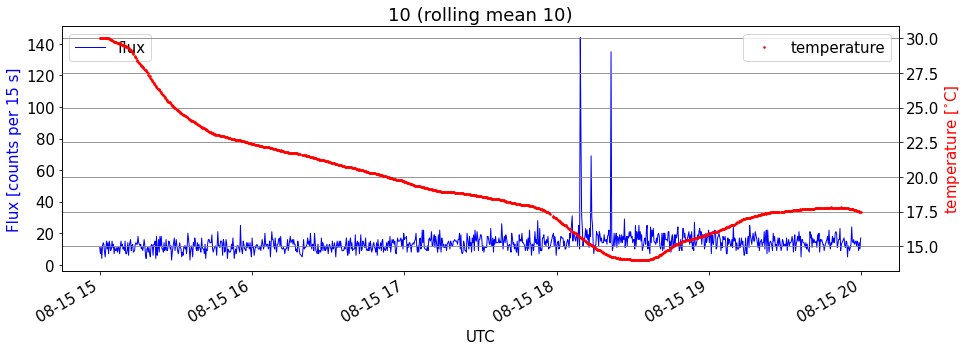

In [18]:
NOISE_LEVEL = 0
LAST_CHANNEL = 240
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']
xx = xx.loc['2021-08-15 15:00:00':'2021-08-15 20:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



# Blitzortung

In [19]:
lat=49.0640992 # Polednik
lon=13.3950208

start=pd.Timestamp('2021-08-15 12:00')
end=pd.Timestamp('2021-08-16 18:00')

BLITZ_DIST = 60

print(start, end, lat, lon)
region=1

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)
try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
blitz = blitz.loc[blitz['km'] < BLITZ_DIST]
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
#blitz.reset_index(inplace=True)
#blitz.set_index('date', inplace=True)

blitz.to_csv(dto + "/blitz.csv")

print('end')

2021-08-15 12:00:00 2021-08-16 18:00:00 49.0640992 13.3950208
No columns to drop (alt, pol, region)
end


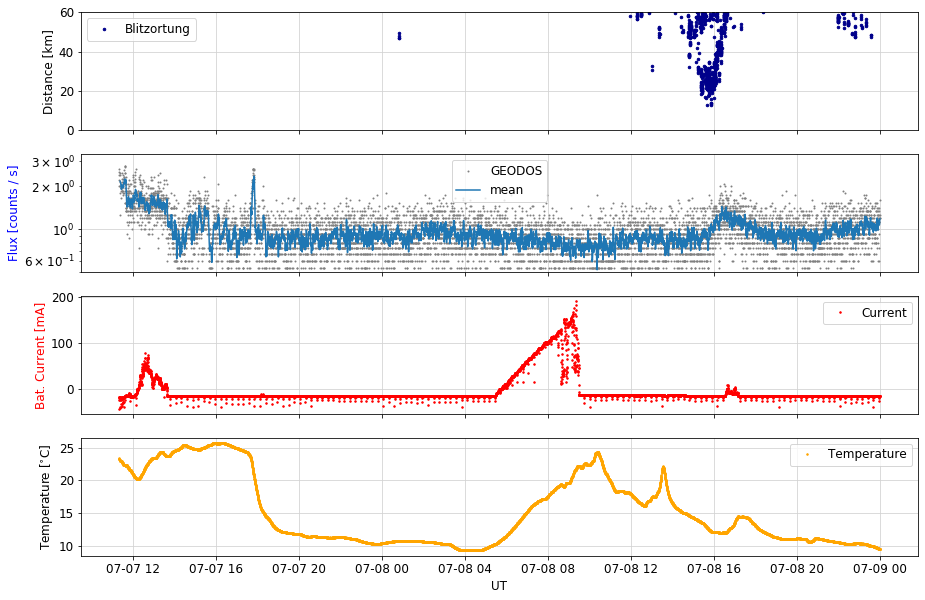

In [52]:
WINDOW = 10

FROM = '2021-07-07 00:00:00'
TO = '2021-07-09 00:00:00'

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']
xx = xx.loc[FROM:TO]

blitzblitz = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
ax3.set_yscale('log')
ax3.set_ylim(0.5,)
ax3.legend()

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(blitzblitz.index, blitzblitz.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


# Energy Spectrum

/tmp/ipykernel_15856/2159348556.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']


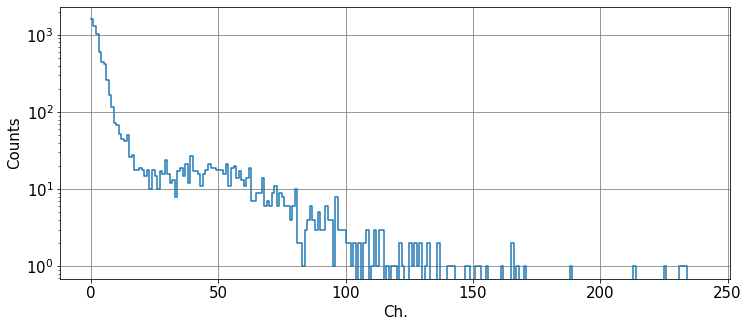

In [19]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

#yy = yy.loc['2021-08-15 11:00:00':'2021-08-16 18:00:00']
yy = yy.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
#yy = yy.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#yy = yy.loc['2021-07-08 17:00:00':'2021-07-08 18:00:00']

#yy = yy.loc['2021-05-12 11:20:00':'2021-05-12 11:30:00']
#yy = yy.loc['2021-05-12 13:58:00':'2021-05-12 14:20:00']

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:240].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([0,30])

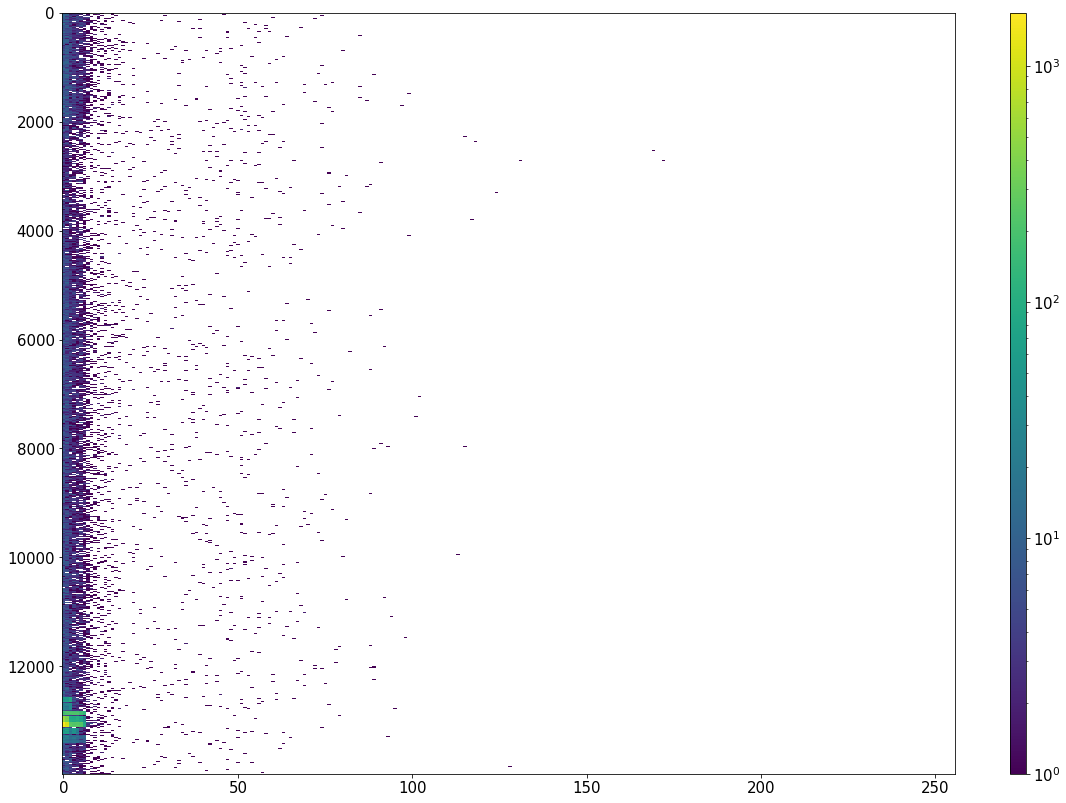

In [13]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:256]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

(0, 30)

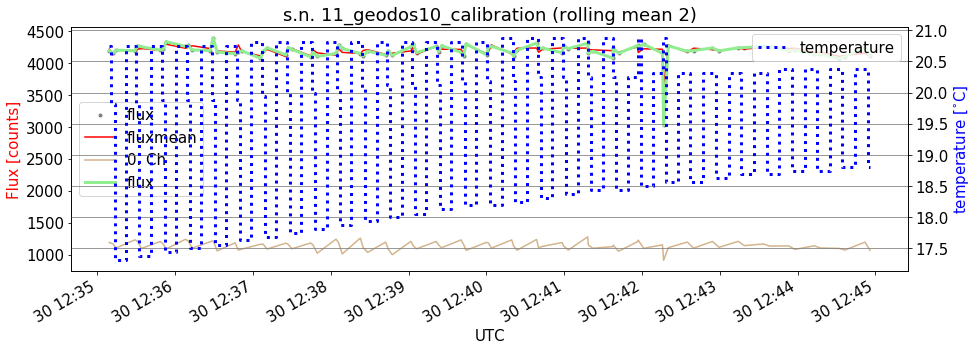

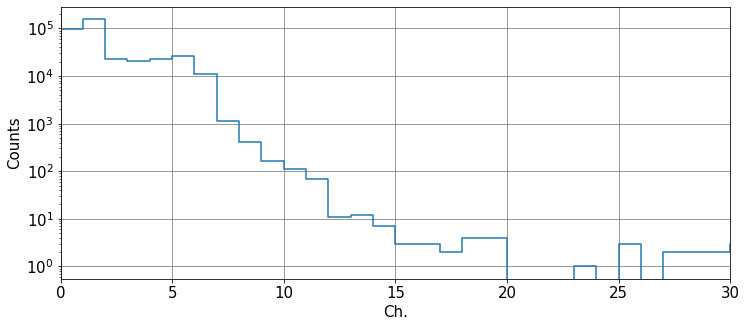

In [99]:
NOISE_LEVEL = 0
LAST_CHANNEL = 256
WINDOW = 2

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2021-05-12 8:35:00':'2021-05-12 16:00:00']
xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
#yy = xx.loc['2021-05-12 11:05:00':'2021-05-12 11:30:00']
yy = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)
yy['flux'].plot(c='lightgreen', linewidth='3')

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:240].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.xlim([0,30])

In [105]:
l = np.array([[1, 1],[5,1]]) # Calibration
r = np.array([0.511, 1.275])
coef = np.linalg.solve(l,r)
print (coef[0], coef[1])
255  * coef[0] + coef[1]

0.19099999999999998 0.32


49.02499999999999

In [110]:
49/4

12.25